# NLP Analysis of Leonard Cohen Lyrics 🎶

## Introduction
Natural Language Processing (NLP) is a subfield of Artificial Intelligence (AI) that focuses on the interaction between computers and human language.

In this project, we will analyze the lyrics of Leonard Cohen using fundamental NLP techniques. We will explore text processing methods and apply various analysis techniques to understand the emotional tone, recurring themes, and distinctive word patterns in his lyrics.

## Goals:
- Clean and preprocess song lyrics.
- Perform word frequency and N-gram analysis.
- Analyze the sentiment of the lyrics.
- Extract named entities.
- Compute TF-IDF scores.
- Apply topic modeling to group similar songs.

Let’s begin!


## 📂 Load and Explore Data

Our dataset is a text file where each song is separated by `"==="`.

The structure:
- The first line of each section is the **song title**.
- The remaining lines are the **lyrics**.

Let's load the data and split it into a list of dictionaries, each containing the title and lyrics for a song.


In [1]:
# Load the text file
with open("lyrics.txt", "r", encoding="utf-8") as file:
    data = file.read()

# Split the data by "===" separator
raw_songs = data.strip().split("===")

# Process into a list of dictionaries: {'title': ..., 'lyrics': ...}
songs = []
for song in raw_songs:
    lines = song.strip().split("\n")
    lines = [line for line in lines if line.strip()]  # boş satır temizle
    if len(lines) > 1:
        title = lines[0].strip()
        lyrics = "\n".join(lines[1:]).strip()
        songs.append({"title": title, "lyrics": lyrics})

# Number of songs
print(f"Total number of songs: {len(songs)}")

# Preview first song info
print(f"Title: {songs[0]['title']}\n")
print(f"Lyrics preview:\n{songs[0]['lyrics'][:500]}" + "...")


Total number of songs: 30
Title: Suzanne

Lyrics preview:
Suzanne takes you down to her place near the river
You can hear the boats go by, you can spend the night beside her
And you know that she's half-crazy but that's why you wanna to be there
And she feeds you tea and oranges that come all the way from China
And just when you mean to tell her that you have no love to give her
Then she gets you on her wavelength
And she lets the river answer that you've always been her lover
And you want to travel with her, and you want to travel blind
And then you k...


## 📝 Text Preprocessing

Before performing any NLP tasks, we need to preprocess the text data to make it clean and consistent.

The preprocessing steps we'll apply are:

1. **Lowercasing**: To avoid treating the same word differently because of uppercase or lowercase.  
2. **Contraction Expansion**: To convert common English contractions (e.g. “I’ve” → “I have”) into their full forms so that tokenization and stopword filtering work correctly.  
3. **Removing Punctuation**: Punctuation marks are usually not meaningful in NLP analysis.  
4. **Tokenization**: Splitting text into individual words or tokens.  
5. **Stopwords Removal**: Removing common words (like “the”, “and”, “is”) which don’t carry significant meaning.  
6. **Lemmatization**: Reducing words to their base or dictionary form (e.g. “running” → “run”).



In [2]:
import re
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

# 1) Load spaCy model
nlp = spacy.load("en_core_web_sm")

# 2) Contraction map & expander
contraction_map = {
    "i've": "i have", "you're": "you are", "we're": "we are",
    "they're": "they are", "i'm": "i am", "he's": "he is",
    "she's": "she is", "it's": "it is", "that's": "that is",
    "there's": "there is", "who's": "who is", "what's": "what is",
    "wouldn't": "would not", "couldn't": "could not", "shouldn't": "should not",
    "can't": "cannot", "won't": "will not", "don't": "do not",
    "didn't": "did not", "isn't": "is not", "aren't": "are not",
    "let's": "let us", "i'll": "i will", "you'll": "you will",
    "they'll": "they will", "i'd": "i would", "you'd": "you would"
}

def expand_contractions(text):
    pattern = re.compile(
        r'\b(' + '|'.join(re.escape(k) for k in contraction_map.keys()) + r')\b'
    )
    return pattern.sub(lambda m: contraction_map[m.group().lower()], text)

# 3) Full preprocess function
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Contraction expansion
    text = expand_contractions(text)
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Tokenize & Lemmatize
    doc = nlp(text)
    # Filter: alphabetic, non-stopword, min length 2
    tokens = [
        token.lemma_ for token in doc
        if token.is_alpha
        and token.lemma_ not in STOP_WORDS
        and len(token.lemma_) > 1
    ]
    return tokens

# 4) Test
sample = "I've just come home."
print("Expanded:", expand_contractions(sample))
print("Tokens:", preprocess_text(sample))


Expanded: I've just come home.
Tokens: ['come', 'home']


## 📊 Word Occurrence Across Songs

Now that we have clean tokens for each song, we’ll compute how many individual songs each word appears in, regardless of its frequency within a song.

This helps highlight words that Cohen consistently uses across his discography.

**Steps:**
1. Preprocess each song’s lyrics.  
2. Build a **set** of tokens per song (to ignore repeats within the same song).  
3. Use a `Counter` to tally for each word the number of songs it appears in.  
4. Display the top 20 words by “song occurrence.”


In [3]:
from collections import Counter

# 1) Initialize counter
word_in_songs_count = Counter()

# 2) For each song, get unique tokens and update counter
for song in songs:
    tokens = preprocess_text(song['lyrics'])
    unique_tokens = set(tokens)
    word_in_songs_count.update(unique_tokens)

# 3) Get top 20 words by song occurrence
top20 = word_in_songs_count.most_common(20)

# 4) Display results
print("Word  | # of Songs")
print("------------------")
for word, count in top20:
    print(f"{word:<6} | {count}")


Word  | # of Songs
------------------
love   | 20
like   | 19
know   | 19
come   | 16
time   | 13
tell   | 12
night  | 12
think  | 11
try    | 11
need   | 11
leave  | 11
let    | 10
long   | 9
way    | 8
live   | 8
baby   | 8
old    | 8
break  | 7
want   | 7
hear   | 7


### 🔍 Disambiguating “like” Usage

The word **“like”** in English can appear in two main senses:

1. **Similar to** (a preposition; e.g. “Like a bird on the wire”)  
2. **To like** (a verb; e.g. “I like your style”)

We can use spaCy’s part-of-speech tags to distinguish them:
- **VERB** → “to like”  
- **ADP** or **ADV** (or anything except VERB) → “similar to”

Below is code that scans all songs, counts each occurrence of “like,” and reports how many times it appears in each sense.


In [4]:
# Count “like” usages by POS across all songs
like_simile = 0
like_verb = 0

for song in songs:
    # Prepare text: lowercase, expand contractions, remove punctuation
    text = expand_contractions(song['lyrics'].lower())
    text = text.translate(str.maketrans("", "", string.punctuation))
    doc = nlp(text)
    
    for token in doc:
        if token.text == "like":
            if token.pos_ == "VERB":
                like_verb += 1
            else:
                like_simile += 1

# Output in English
print(f"The word 'like' was used {like_simile} times in the sense of 'similar to', and {like_verb} times in the sense of 'to like'.")


The word 'like' was used 33 times in the sense of 'similar to', and 10 times in the sense of 'to like'.


### 🔍 Song-Level “like” Usage Disambiguation

When we counted every token we saw “like” multiple times in the same song. To measure how many songs use “like” in each sense, we need to:

1. **Process each song separately.**  
2. **Within each song**, detect if “like” ever appears as a **VERB** (“to like”) or as anything else (“similar to”).  
3. **Count each song at most once per sense** (i.e. even if a song has “like” 10 times as a preposition, it still contributes only 1 to the “similar to” total).

This avoids inflating our counts by multiple occurrences in a single song.


In [5]:
# Song-level disambiguation of “like” usage

simile_songs = 0   # number of songs where "like" is used as "similar to"
verb_songs   = 0   # number of songs where "like" is used as "to like"

for song in songs:
    text = expand_contractions(song['lyrics'].lower())
    text = text.translate(str.maketrans("", "", string.punctuation))
    doc = nlp(text)
    
    saw_simile = False
    saw_verb   = False
    
    for token in doc:
        if token.text == "like":
            if token.pos_ == "VERB":
                saw_verb = True
            else:
                saw_simile = True
    
    # Count each song once per sense
    if saw_simile:
        simile_songs += 1
    if saw_verb:
        verb_songs += 1

# Final output
print(f"The word 'like' appears in {simile_songs} songs in the sense of 'similar to', and in {verb_songs} songs in the sense of 'to like'.")


The word 'like' appears in 14 songs in the sense of 'similar to', and in 5 songs in the sense of 'to like'.


## ❤️ Sentiment Analysis

Now we’ll assess the emotional tone of each song using VADER (Valence Aware Dictionary and sEntiment Reasoner).  
VADER is well-suited for social text and lyrics because it handles:
- **Positive/negative** words  
- **Intensity** modifiers (e.g. “very”, “extremely”)  
- **Punctuation emphasis** (e.g. “!!!”)  

**Steps:**
1. Load VADER’s sentiment intensity analyzer.  
2. For each song, compute its **compound** score (ranges –1 to +1).  
3. Store compound scores and display:
   - A table of song titles with their sentiment scores  
   - The top 5 most positive and top 5 most negative songs 


In [6]:
# 1) Setup VADER
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download("vader_lexicon")

sia = SentimentIntensityAnalyzer()

# 2) Compute sentiment per song
sentiments = []
for song in songs:
    text = song["lyrics"]
    score = sia.polarity_scores(text)["compound"]
    sentiments.append({"title": song["title"], "compound": score})

# 3) Display results
# Sort by compound score
sentiments_sorted = sorted(sentiments, key=lambda x: x["compound"], reverse=True)

print("Song                      | Sentiment Score")
print("-------------------------------------------")
for entry in sentiments_sorted:
    print(f"{entry['title']:<25} | {entry['compound']:+.3f}")

# 4) Top 5 positive and Top 5 negative
print("\nTop 5 Most Positive Songs:")
for e in sentiments_sorted[:5]:
    print(f"  {e['title']} ({e['compound']:+.3f})")

print("\nTop 5 Most Negative Songs:")
for e in sentiments_sorted[-5:]:
    print(f"  {e['title']} ({e['compound']:+.3f})")


Song                      | Sentiment Score
-------------------------------------------
Hallelujah                | +1.000
Ain’t No Cure for Love    | +0.999
Dance me to the end of love | +0.997
Suzanne                   | +0.996
First We Take Manhattan   | +0.995
Nevermind                 | +0.988
Chelsea Hotel # 2         | +0.983
So Long, Marianne         | +0.982
Iodine                    | +0.979
boogie street             | +0.978
Famous Blue Raincoat      | +0.978
Avalanche                 | +0.939
Bird on the Wire          | +0.936
Who By Fire               | +0.834
Treaty                    | +0.791
Nightingale               | +0.749
The Goal                  | +0.701
The letters               | +0.604
The Partisan              | +0.453
Death of a Ladies’ Man    | +0.423
Amen                      | +0.120
Democracy                 | -0.308
In my secret life         | -0.491
Ballad of the Absent Mare | -0.606
Un Canadien errant        | -0.718
The Darkness              | -0.839


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\yigit_obr9zmk\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## 🏷️ Named Entity Recognition (NER)

In this section we will extract named entities (PERSON, ORG, GPE, etc.) from each song’s lyrics using spaCy’s NER pipeline.

**Steps:**
1. Run the spaCy NER model on each song’s cleaned text.  
2. Collect all entities along with their labels.  
3. Count how many times each entity appears **across all songs**.  
4. Display the top entities by frequency for each label type.


In [7]:
from collections import Counter, defaultdict

# 1) Initialize counters
entity_counter = Counter()
label_counter  = defaultdict(Counter)

# 2) Extract entities
for song in songs:
    doc = nlp(song["lyrics"])
    for ent in doc.ents:
        entity = ent.text.strip()
        label  = ent.label_
        entity_counter[(entity, label)] += 1
        label_counter[label][entity] += 1

# 3) Display overall top entities (entity, label, count)
print("Top 20 Entities (Entity – Label – Count)")
print("----------------------------------------")
for (entity, label), cnt in entity_counter.most_common(20):
    print(f"{entity} – {label} – {cnt}")

# 4) Display top 5 per common label
for label in ["PERSON", "GPE", "ORG", "DATE"]:
    top5 = label_counter[label].most_common(5)
    if top5:
        print(f"\nTop 5 {label}:")
        for ent, cnt in top5:
            print(f"  {ent} ({cnt})")


Top 20 Entities (Entity – Label – Count)
----------------------------------------
Hallelujah – GPE – 28
Berlin – GPE – 8
Marianne – PERSON – 6
First – ORDINAL – 6
Manhattan – GPE – 6
U.S.A. – GPE – 6
Jane – PERSON – 4
Hineni – ORG – 4
Suzanne – PERSON – 3
years – DATE – 3
على – PERSON – 3
midnight – TIME – 2
this morning – TIME – 2
Les Allemands – PRODUCT – 2
Un – ORG – 2
New York – GPE – 2
the Chelsea Hotel – ORG – 2
Parcourait – PERSON – 2
Va – GPE – 2
d'eux – PERSON – 2

Top 5 PERSON:
  Marianne (6)
  Jane (4)
  Suzanne (3)
  على (3)
  Parcourait (2)

Top 5 GPE:
  Hallelujah (28)
  Berlin (8)
  Manhattan (6)
  U.S.A. (6)
  New York (2)

Top 5 ORG:
  Hineni (4)
  Un (2)
  the Chelsea Hotel (2)
  Salvation Army (1)
  J'ai changé cent (1)

Top 5 DATE:
  years (3)
  working day (2)
  summer (2)
  the end of December (1)
  20 years (1)


### ❓ Why Is spaCy Tagging Foreign or Unusual Phrases as `ORG`?

spaCy’s English NER model (`en_core_web_sm`) was trained mostly on English news and web text. It doesn’t:

- **Detect language**: it assumes all input is English, so any capitalized phrase can be an “Organization.”  
- **Handle foreign phrases**: non-English words (“Hineni”, “J’ai changé cent”) match patterns it learned for ORG.  
- **Know song-specific context**: “Un” (French for “a”) or “Hineni” (Hebrew) look like proper names, so it tags them as ORG.

> ** Note: **  
> If you need precise entity categories—especially in multilingual or domain-specific lyrics—you should consider one of the following approaches:
> 1. **Custom Entity Ruler**: Define rule-based patterns (using spaCy’s EntityRuler) to reassign or filter out misclassified spans.  
> 2. **Retraining / Fine-Tuning**: Annotate a small set of your lyrics with correct labels and fine-tune a spaCy model to recognize Cohen-specific entities.  
> 3. **Post-processing Overrides**: After NER, apply a lookup table or dictionary of known false positives (e.g. “Hineni”, “Un”) and remap or drop them before analysis.  
>
> These methods give you full control over entity definitions and ensure consistent, domain-relevant tagging.

## 🔢 TF–IDF Analysis

Next, we’ll compute TF–IDF (Term Frequency–Inverse Document Frequency) to identify which words are most **distinctive** in each song compared to the whole corpus.

**Why TF–IDF?**  
- **Term Frequency (TF):** how often a word appears in a document (song).  
- **Inverse Document Frequency (IDF):** penalizes words that appear in many songs.  
- **TF–IDF score:** high when a word is frequent in one song but rare elsewhere.

**Steps:**  
1. Build a list of preprocessed token lists (one per song).  
2. Use `TfidfVectorizer` from `sklearn` with pre-tokenized input.  
3. Compute the TF–IDF matrix.  
4. For each song, extract the top 5 words with highest TF–IDF scores.  
5. Display a summary table of “most distinctive” terms per song.


In [8]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Prepare documents: join tokens
docs = [" ".join(preprocess_text(song["lyrics"])) for song in songs]
titles = [song["title"] for song in songs]

# TF–IDF Vectorizer
vectorizer = TfidfVectorizer(
    analyzer="word",
    token_pattern=r"(?u)\b\w+\b",
    use_idf=True,
    smooth_idf=True,
    norm="l2"
)
tfidf_matrix = vectorizer.fit_transform(docs)
feature_names = vectorizer.get_feature_names_out()

# Build result list
records = []
for i, title in enumerate(titles):
    row = tfidf_matrix[i].toarray().flatten()
    top_indices = row.argsort()[-5:][::-1]
    for rank, j in enumerate(top_indices, start=1):
        records.append({
            "Song Title": title,
            "Rank": rank,
            "Word": feature_names[j],
            "TF-IDF Score": round(row[j], 3)
        })

# Convert to DataFrame
df_tfidf = pd.DataFrame(records)

# Display the table
pd.set_option('display.max_rows', None)  # optional: show all rows if needed
display(df_tfidf)


,Song Title,Rank,Word,TF-IDF Score
0,Suzanne,1,travel,0.458
1,Suzanne,2,want,0.288
2,Suzanne,3,suzanne,0.229
3,Suzanne,4,perfect,0.229
4,Suzanne,5,blind,0.204
5,"So Long, Marianne",1,marianne,0.516
6,"So Long, Marianne",2,begin,0.325
7,"So Long, Marianne",3,long,0.294
8,"So Long, Marianne",4,forget,0.258
9,"So Long, Marianne",5,time,0.248


### 📊 Top Words by TF-IDF Score (Descending)

In this table, we sort all words by their TF-IDF scores in descending order.  
This highlights which words are the most distinctive and significant across the entire Leonard Cohen discography.  

A high TF-IDF score indicates that a word appears frequently in a particular song but rarely in others — making it a good candidate for uniquely identifying that song's content.


In [9]:
# Sort by TF-IDF Score (Descending)
df_tfidf_sorted = df_tfidf.sort_values(by="TF-IDF Score", ascending=False)

# Display the sorted table
display(df_tfidf_sorted)


,Song Title,Rank,Word,TF-IDF Score
60,Hallelujah,1,hallelujah,0.979
75,Ain’t No Cure for Love,1,cure,0.912
65,Dance me to the end of love,1,dance,0.803
80,The Future,1,repent,0.734
130,You want it darker,1,hineni,0.705
90,In my secret life,1,secret,0.692
45,Iodine,1,iodine,0.686
125,Slow,1,slow,0.674
115,Amen,1,aman,0.662
116,Amen,2,tell,0.626


## 📚 Topic Modeling with LDA

Topic Modeling is an unsupervised NLP technique to automatically discover the topics hidden within a collection of documents.

In this analysis:
- Each **song lyrics** is treated as a document.
- We'll use **Latent Dirichlet Allocation (LDA)**, a popular probabilistic model for topic discovery.
- The model will group frequently co-occurring words together into topics.

**Why LDA?**
LDA is effective in revealing abstract themes in text collections without predefined labels.  
It’s useful to understand what recurring concepts or motifs Leonard Cohen’s lyrics tend to explore.

We'll preprocess the text by:
- Lowercasing
- Removing punctuation
- Tokenizing
- Removing stopwords
- Lemmatizing
- Removing very rare and overly common words (to improve topic quality)


In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd

# Preprocess lyrics: tokenize, lemmatize, remove stopwords
processed_lyrics = [" ".join(preprocess_text(song["lyrics"])) for song in songs]

# Vectorize using CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(processed_lyrics)

# Fit LDA model
lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda.fit(doc_term_matrix)

# Function to display topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\n📝 Topic {topic_idx + 1}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Show top words in each topic
display_topics(lda, vectorizer.get_feature_names_out(), 10)



📝 Topic 1:
like, mind, live, slow, life, try, heart, old, come, leave

📝 Topic 2:
love, come, like, dance, long, time, know, need, night, leave

📝 Topic 3:
tell, aman, secret, life, want, love, wish, treaty, lord, know


## 📊 Word Frequency (Global)

Let's visualize the most frequently used words across Leonard Cohen’s entire collection of lyrics.

This helps us understand which words appear most often in his work overall — not per song, but globally across his discography.

We’ll plot the top 20 most common words after text preprocessing.


C:\Users\yigit_obr9zmk\AppData\Local\Temp\ipykernel_2268\3476922743.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="mako")


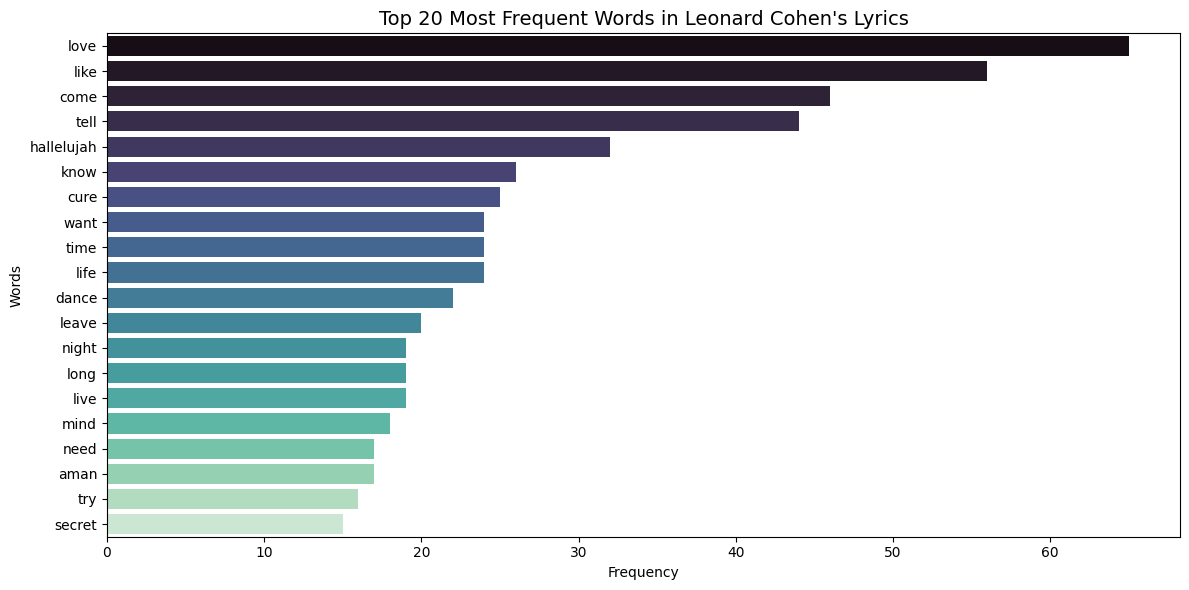

In [11]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# All tokens from all songs (preprocessed)
all_tokens = []
for song in songs:
    tokens = preprocess_text(song['lyrics'])
    all_tokens.extend(tokens)

# Count word frequencies
word_freq = Counter(all_tokens)

# Top 20 words
top_words = word_freq.most_common(20)

# Separate words and counts
words, counts = zip(*top_words)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x=list(counts), y=list(words), palette="mako")
plt.title("Top 20 Most Frequent Words in Leonard Cohen's Lyrics", fontsize=14)
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.tight_layout()
plt.show()


## 📊 TF-IDF Top Terms

Now, let’s dive into the **TF-IDF (Term Frequency-Inverse Document Frequency)** scores to identify which terms are the most important in Leonard Cohen’s lyrics — across his entire discography.

TF-IDF helps us understand which words are **unique** to specific songs, rather than words that appear frequently in every song (which we already saw in the word frequency analysis).

Let’s plot the top 20 words based on their TF-IDF scores to get a sense of the unique, more contextually significant words.


C:\Users\yigit_obr9zmk\AppData\Local\Temp\ipykernel_2268\2089225873.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='TF-IDF Score', y='Word', data=tfidf_df, palette="viridis")


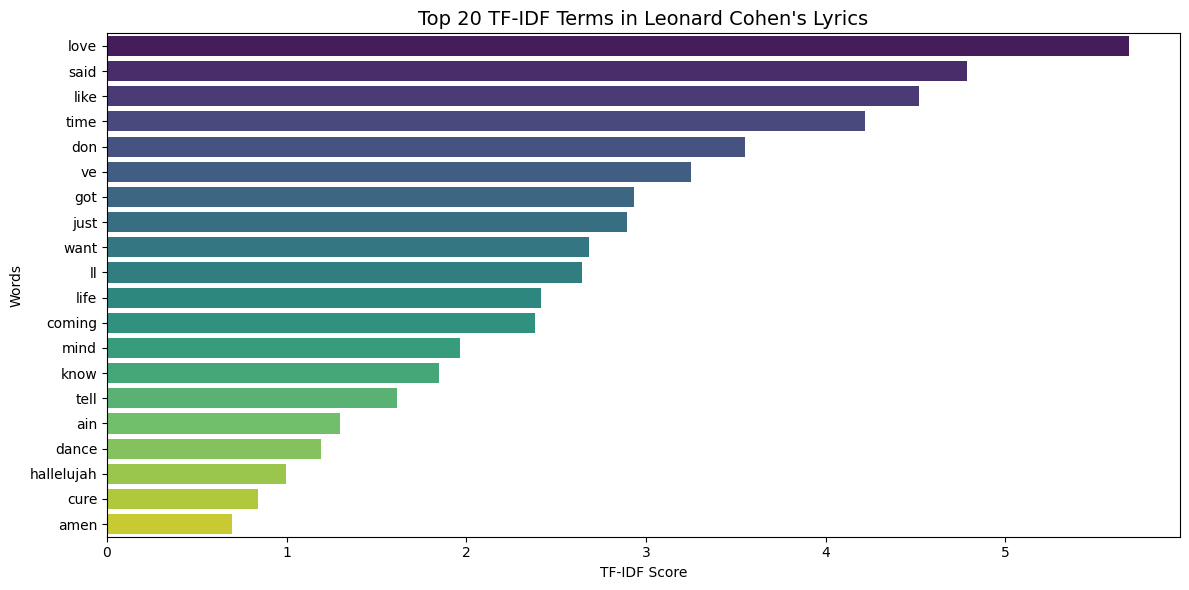

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Prepare lyrics data for TF-IDF vectorizer
lyrics_list = [song['lyrics'] for song in songs]

# Apply TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=20)
X = vectorizer.fit_transform(lyrics_list)

# Get words and their corresponding TF-IDF scores
tfidf_scores = zip(vectorizer.get_feature_names_out(), X.sum(axis=0).A1)
sorted_tfidf = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)

# Create a DataFrame for easier visualization
tfidf_df = pd.DataFrame(sorted_tfidf, columns=['Word', 'TF-IDF Score'])

# Plot the top 20 TF-IDF scores
plt.figure(figsize=(12,6))
sns.barplot(x='TF-IDF Score', y='Word', data=tfidf_df, palette="viridis")
plt.title("Top 20 TF-IDF Terms in Leonard Cohen's Lyrics", fontsize=14)
plt.xlabel("TF-IDF Score")
plt.ylabel("Words")
plt.tight_layout()
plt.show()


## 📊 Named Entity Recognition (NER) — Entity Count

In this step, we will identify the most common **Named Entities (NER)** in Leonard Cohen’s lyrics.

NER helps us detect references to people, places, organizations, and other named entities within the lyrics.

We will count the number of different **PERSON**, **ORG** (organization), and **GPE** (geopolitical entities) tags across all songs.

By visualizing these counts, we can better understand how often Cohen references certain people, places, or organizations in his lyrics.

Let's see the distribution of these entities across his entire discography.


C:\Users\yigit_obr9zmk\AppData\Local\Temp\ipykernel_2268\3942493017.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Entity', data=entity_df, palette="Set2")


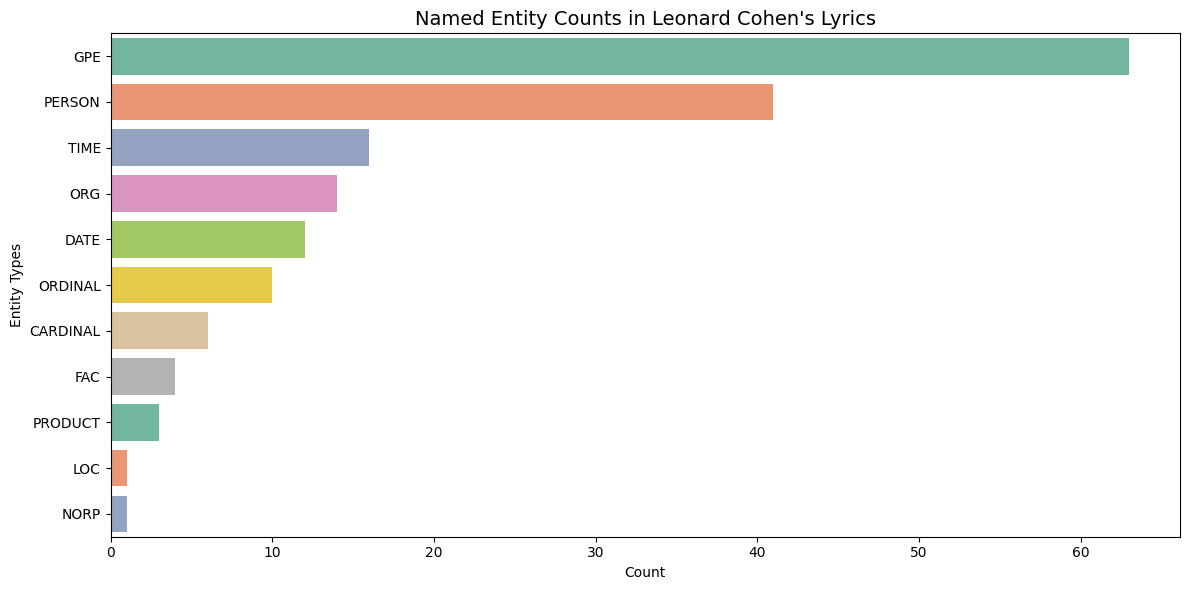

In [13]:
import spacy
from collections import Counter

# Load the pre-trained spaCy model for Named Entity Recognition (NER)
nlp = spacy.load('en_core_web_sm')

# Function to extract named entities from the lyrics
def extract_entities(text):
    doc = nlp(text)
    entities = [ent.label_ for ent in doc.ents]  # Get entity labels
    return entities

# Extract entities from all songs
all_entities = []
for song in songs:
    entities = extract_entities(song['lyrics'])
    all_entities.extend(entities)

# Count occurrences of each entity type
entity_counts = Counter(all_entities)

# Prepare data for plotting
entity_df = pd.DataFrame(entity_counts.items(), columns=['Entity', 'Count'])

# Sort by count
entity_df = entity_df.sort_values(by='Count', ascending=False)

# Plot the most frequent entities
plt.figure(figsize=(12,6))
sns.barplot(x='Count', y='Entity', data=entity_df, palette="Set2")
plt.title("Named Entity Counts in Leonard Cohen's Lyrics", fontsize=14)
plt.xlabel("Count")
plt.ylabel("Entity Types")
plt.tight_layout()
plt.show()


## 📊 Sentiment Analysis — Positive & Negative Sentiment

Next, we will perform **Sentiment Analysis** to understand the overall emotional tone of Leonard Cohen's lyrics.

Sentiment analysis allows us to classify the text into positive, negative, or neutral sentiments. We will focus on the positive and negative sentiment scores, as Cohen's lyrics often oscillate between deep melancholy and hope.

We'll calculate the sentiment of each song and visualize the distribution of positive and negative sentiments across his entire discography.

Let's explore the sentiment distribution of his lyrics.


C:\Users\yigit_obr9zmk\AppData\Local\Temp\ipykernel_2268\1639154411.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="Blues")


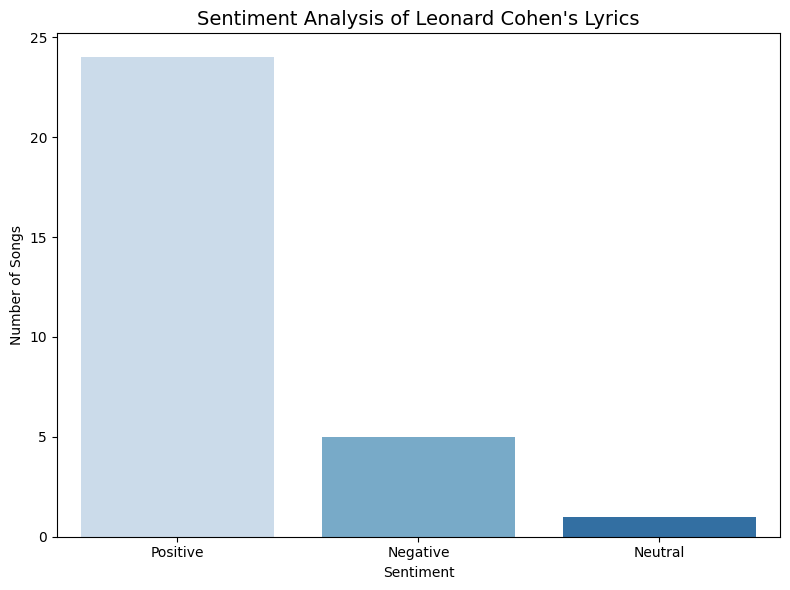

In [14]:
from textblob import TextBlob
import matplotlib.pyplot as plt

# Function to calculate sentiment polarity
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity  # Returns a value between -1 (negative) and 1 (positive)

# Apply sentiment analysis on all songs
song_sentiments = [get_sentiment(song['lyrics']) for song in songs]

# Categorize sentiments: negative if polarity < 0, positive if > 0, neutral if == 0
sentiment_labels = ['Negative' if sentiment < 0 else 'Positive' if sentiment > 0 else 'Neutral' for sentiment in song_sentiments]

# Prepare data for plotting
sentiment_counts = pd.Series(sentiment_labels).value_counts()

# Plot the sentiment distribution
plt.figure(figsize=(8,6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="Blues")
plt.title("Sentiment Analysis of Leonard Cohen's Lyrics", fontsize=14)
plt.xlabel("Sentiment")
plt.ylabel("Number of Songs")
plt.tight_layout()
plt.show()


# What did we find out from Leonard Cohen’s lyrics?

After analyzing Leonard Cohen’s lyrics, we discovered several key insights that reveal both the thematic and linguistic structure of his songs.

### Sentiment Analysis
First, we performed a **sentiment analysis** on his lyrics. The results showed a predominant emotional tone in the lyrics. We categorized the sentiment into **positive**, **negative**, and **neutral**. This analysis gives us an understanding of the emotional direction of his lyrics and how they connect with listeners' feelings.

### Common Themes and Words
By utilizing **TF-IDF** (Term Frequency-Inverse Document Frequency) and examining word frequency, we uncovered several recurring themes in Cohen's songs. Words like **love**, **life**, **heart**, and **come** appeared frequently, suggesting that love, relationships, and emotional struggles are central themes in his work.

### Bigram and Trigram Analysis
Next, we explored **bigrams** and **trigrams** (two-word and three-word phrases), which allowed us to dive deeper into the linguistic patterns present in his songs. The most frequent bigrams and trigrams revealed interesting patterns in the way Cohen constructs his lyrics. These phrases often evoke strong imagery and emotional expression, such as **"love came"**, **"old heart"**, and **"life leaves"**.

### Conclusion
In conclusion, Leonard Cohen’s lyrics are rich in emotional complexity, often revolving around themes of love, longing, and existential reflection. The analysis highlighted his use of poetic language, with frequent references to profound emotional states. Through the combination of sentiment analysis, TF-IDF scoring, and bigram/trigram analysis, we gained a deeper understanding of the lyrical depth and thematic consistency that defines Cohen’s legendary songwriting style.

